In [1]:
import sys
import os
import gc

package_path = os.path.join(os.getcwd(), "packages/")
if package_path not in sys.path:
    sys.path.insert(0, package_path)

import PubChemHazardAPI
import PubChemBioactivityAPI
import PubChemIdentifiers
import PubMedAPI
import AssayData
import ChemblAPI
import CTXAPI

import LLMAnalysis # this involves loading a huggingface model (BioGPT-Large) so expect the import block to take a little while - also expect some loading bars. If it's bugging you just comment it out
                   # I will point out the single block that uses it later

from tqdm import tqdm
import time
import json

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv


I wanted to develop an example sheet of how some of these python for wrappers for public APIs could be useful. Also there's some cool LLM stuff. It was a fun weekend project.

I zeroed in on the sort of thing a risk-concerned toxicologist would want to consider during an assessment. Does the literature say it's scary? Does it show activity in in vitro NAMs? Will it absorb through the skin? Etc. Etc. I therefore selected tools and a workflow from this perspective. Please ask me any question you'd like about supervised machine learning if that is of specific interest.

If the assignment was directly a QSAR *or* a chemical without a large amount of data I would dive into read-across (automated by GenRA or an in-house similarity approach) and use the systems I developed and applied here to begin characterizing similar compounds that have data. 

In [2]:
print(os.getcwd())

C:\Users\Nate\Documents\Projects\2025\ChemicalToxAnalysis


In [3]:
CHEMICAL_NAME = 'atrazine' # common pesticide - good test case!

load_dotenv()
CTX_API_KEY = os.getenv("CTX_API_KEY")
if not CTX_API_KEY:
    raise ValueError("API key not found. Please set CTX_API_KEY in your .env file.") # email the EPA for your own key if you don't have one!

In [4]:
inchi_key = PubChemIdentifiers.inchi_from_name(CHEMICAL_NAME)
# I don't generally trust preferred names so I'm going to convert to Inchi for tracking purposes. In a production environment we would need to be careful in how we map preferred name to Inchikey
# Confining scope to handling compounds. Substances would require more upstream handling/thinking
pubchem_cid = PubChemIdentifiers.pubchem_cid_from_inchi(inchi_key)

In [5]:
assays = PubChemBioactivityAPI.pubchem_bioactivity_summary(pubchem_cid)
bioactivity_summary = PubChemBioactivityAPI.bioactivity_json_to_dframe(assays)
bioactivity_summary = bioactivity_summary.loc[bioactivity_summary['Activity Outcome'] == 'Active']

try: 
    with open(os.path.join(os.getcwd(), f"assay_desc_{pubchem_cid}.json"), "r") as fin:
        tox_assays = json.load(fin)
except:
    print("No JSON detected. Analyzing assays.")
    tox_assays = {}
    for aid in tqdm(bioactivity_summary['AID'], desc="Detecting Relevant Assays"):
        assay_desc = PubChemBioactivityAPI.assay_description(aid)
        relevance = AssayData.tox_keyword_hits(assay_desc)
        if relevance != None:
            tox_assays[aid] = {"keywords" : relevance, "desc" : assay_desc}
        # avoid angering pubchem gods - stick to < 5 requests / sec
        time.sleep(0.21)
    with open(os.path.join(os.getcwd(), f"assay_desc_{pubchem_cid}.json"), "w") as fout:
        json.dump(tox_assays, fout, indent=2)

BA_summary = AssayData.summarize_assay_data(tox_assays)
GHS_summary = PubChemHazardAPI.summarize_hazard_codes(PubChemHazardAPI.extract_ghs_hazard_codes(pubchem_cid))

print(BA_summary)
print(GHS_summary['GHS Definitions'])


{'developmental': 1, 'mutagen': 2, 'CYP': 3}
['Harmful if swallowed Acute toxicity, oral', 'May cause an allergic skin reaction Skin sensitization', 'Causes serious eye irritation Serious eye damage/eye irritation', 'Causes eye irritation Serious eye damage/eye irritation', 'May be harmful if inhaled Acute toxicity, inhalation', 'Suspected of damaging fertility or the unborn child Reproductive toxicity', 'May cause damage to organs Specific target organ toxicity, single exposure', 'May cause damage to organs through prolonged or repeated exposure Specific target organ toxicity, repeated exposure', 'Very toxic to aquatic life Hazardous to the aquatic environment, acute hazard', 'Very toxic to aquatic life with long lasting effects Hazardous to the aquatic environment, long-term hazard']


In [6]:
tox_assays['1259392'] # pulling the 'developmental' record by its AID. It looks like activity in this assay might represent a genuine devtox concern, but it's hardly an in vivo study

{'keywords': ['developmental'],
 'desc': ['U.S. Tox21 Program',
  '',
  'National Center for Advancing Translational Sciences [NCATS]',
  'NIH Chemical Genomics Center [NCGC]',
  'U.S. Environmental Protection Agency [EPA]',
  'National Institutes of Environmental Health Sciences [NIEHS]',
  'National Toxicology Program [NTP]',
  'U.S. Food and Drug Administration [FDA]',
  '',
  'Tox21 Assay Overview:',
  '',
  'The sonic hedgehog (Shh) pathway is essential for normal embryonic development. Dysregulation of the Shh pathway can cause severe developmental defects in organs. Therefore chemicals that interfere with the pathway are potential developmental toxicants. A cell line designated 3T3Gli1-Luc (DMB/OARSA/CFSAN/FDA, Laurel, MD), a NIH/3T3 derived clone containing stably integrated Gli1-Luc reporter is used to detect chemical interference of the Shh pathway, by changes in the expression of the firefly Luc gene under the control of the Gli1 transcriptional response element. This cell l

In the context of further investigating the toxicology of this molecule I would also be interested in the scientific literature. The bioactivity data flagged developmental toxicity, so let's grab some abstracts from the past year with keywords 'atrazine', 'developmental', and 'toxicity'

In [7]:
pmids = PubMedAPI.get_pubmed_ids(CHEMICAL_NAME, keywords=['developmental', 'toxicity'], max_results=10)
first_abstract = PubMedAPI.get_abstract(pmids[0])
print(first_abstract)

1. Int J Mol Sci. 2024 Dec 5;25(23):13066. doi: 10.3390/ijms252313066.

Integrated Analysis of Neuroendocrine and Neurotransmission Pathways Following 
Developmental Atrazine Exposure in Zebrafish.

Stradtman SC(1), Swihart JN(1), Moore K(1), Akoro IN(1), Ahkin Chin Tai JK(1), 
Tamagno WA(1), Freeman JL(1).

Author information:
(1)School of Health Sciences, Purdue University, West Lafayette, IN 47907, USA.

Atrazine is an endocrine-disrupting herbicide, with exposure impacting adverse 
outcomes along multiple endocrine pathways. This study investigated the 
neuroendocrine system as the central target of atrazine toxicity, examining 
effects of early developmental exposures on neurohormones and genes associated 
with kisspeptin, hypothalamic, pituitary, and dopamine systems. Zebrafish were 
exposed to 0, 0.3, 3, or 30 ppb (µg/L) atrazine during two developmental time 
windows. For neurohormone assessments, exposure was ceased at the end of 
embryogenesis (72 h post-fertilization, hpf) a

Personally I have no issue reading the literature, but let's have some more fun with it. I wanted to explore the utility of an LLM for getting simplied but representative summaries of the abstracts recovered from pubmed. Please note: this method is rough. I think there's promise but it requires development and validation outside the scope of this assignment, and more careful validation the LLM is consistently delivering a reliable summary. Honestly I just thought it was a fun idea to explore.

This function downloads and runs BioGPT-Large from HuggingFace so it will be memory and processor hungry. In a perfect world I'd have an api key to more advanced models, but they charge a corporate rate.

*If you commented out the LLM import earlier this block will not work. It will take a little while for the model to do its thing. Also the models are currently stochastic...there's a way to fix the seed for reproducibility but I would need to dig into it*

In [8]:
llm_key_findings = {}
for pmid in pmids:
    key_finding = LLMAnalysis.key_finding(PubMedAPI.get_abstract(pmid))
    llm_key_findings[pmid] = key_finding
    print(f"{pmid}\n {key_finding}\n")

39684776
 Developmental atrazine exposure impacts sex-specific neurohormonal pathways in zebrafish. The findings are in alignment with data from the current literature indicating that atrazine is an endocrine disruptor with effects on the hypothalamus-pituitary-gonadal axis, affecting both the brain and reproductive organs. The current findings are consistent with data from the current literature indicating that atrazine is an endocrine disruptor with effects on the hypothalamus-pituitary-gonadal axis, affecting both the brain and reproductive organs.

39226955
 a systematic analysis of transcriptome data sets of zebrafish exposed to 1 8 environmental chemicals and 14 0 related gene expression profiles identified potential disruptors of spliceosome and ribosome biosynthesis.

39195672
 The current research reviewed the direct toxicity effects and mechanisms of different insecticides and herbicides on zebrafish thyroid functions and indirect toxicity effects originating from thyroid dys

So some interesting results. It looks like the first is most immediately relevant to atrazine.

In [9]:
gc.collect() # going to free up some RAM because that model is big and I found my script getting twitchy

64

In [11]:
pmids

['39684776', '39226955', '39195672', '38896413']

In [12]:
print(PubMedAPI.get_abstract(pmids[0])) # read the abstract

1. Int J Mol Sci. 2024 Dec 5;25(23):13066. doi: 10.3390/ijms252313066.

Integrated Analysis of Neuroendocrine and Neurotransmission Pathways Following 
Developmental Atrazine Exposure in Zebrafish.

Stradtman SC(1), Swihart JN(1), Moore K(1), Akoro IN(1), Ahkin Chin Tai JK(1), 
Tamagno WA(1), Freeman JL(1).

Author information:
(1)School of Health Sciences, Purdue University, West Lafayette, IN 47907, USA.

Atrazine is an endocrine-disrupting herbicide, with exposure impacting adverse 
outcomes along multiple endocrine pathways. This study investigated the 
neuroendocrine system as the central target of atrazine toxicity, examining 
effects of early developmental exposures on neurohormones and genes associated 
with kisspeptin, hypothalamic, pituitary, and dopamine systems. Zebrafish were 
exposed to 0, 0.3, 3, or 30 ppb (µg/L) atrazine during two developmental time 
windows. For neurohormone assessments, exposure was ceased at the end of 
embryogenesis (72 h post-fertilization, hpf) a

Cool! The LLM did a decent job summarizing the abstracts for quick examination.


Let's zero in on human toxicity and some of its APIs. One of the first places I'd check is whether we know anything about its ADME (absorption, distribution, metabolism, excretion) to see if there's quantitative data on things like how much might permeate the skin. I will query ChemBL and its database of ADME activities. There are other resources (PKDB, httk) but I like ChemBL's focus on pharmacology so, for the purposes of this exercise, let's see if it offers any insight into atrazine.

In [13]:
chembl_id = ChemblAPI.chemblid_from_inchi(inchi_key)
assay_type = 'A'
organism = 'Homo sapiens'
types = ['log Kp', 'F', 'Vd', 'CL'] # logKp for skin permeability, F for bioavailability, Vd for volume of distribution, CL for clearance - this should give a good overview of expected ADME if there's data

adme_assays = ChemblAPI.chembl_ADME(chembl_id, organism)
clean_adme = ChemblAPI.clean_ADME(adme_assays, types)
clean_adme

,assay_chembl_id,assay_description,bao_endpoint,target_organism,target_pref_name,type,units,value
0,CHEMBL865441,Permeability in human skin,BAO_0000179,Homo sapiens,Homo sapiens,log Kp,cm/s,-5.56
3,CHEMBL925052,Permeability across human Skin,BAO_0000179,Homo sapiens,Skin,log Kp,None,-5.56


Skin permeability looks to be relatively low for this compound. That's good for something that's not intended for topical administration. It can't do damage if it doesn't get into the body.

Finally let use CTX API and ToxRef to see what in vivo toxicity data is there for assessment.

In [14]:
CTXAPI.get_dtxsid_from_inchikey(inchi_key, CTX_API_KEY)

'DTXSID9020112'

In [15]:
dtxsid = CTXAPI.get_dtxsid_from_inchikey(inchi_key, CTX_API_KEY) # the DTXSID is the core chemical identifier for most USEPA systems
cancer_data = CTXAPI.get_cancer_data(dtxsid, CTX_API_KEY)
print(cancer_data)

[{'id': 2680, 'source': 'EPA OPP', 'url': 'http://www.epa.gov/pesticides/carlist/', 'cancerCall': 'Not Likely to Be Carcinogenic in Humans', 'dtxsid': 'DTXSID9020112', 'exposureRoute': '-'}, {'id': 2681, 'source': 'IARC', 'url': 'https://monographs.iarc.who.int/list-of-classifications/', 'cancerCall': 'Group 3 - Not classifiable as to its carcinogenicity to humans', 'dtxsid': 'DTXSID9020112', 'exposureRoute': '-'}]


In [16]:
ctx_hazard = CTXAPI.get_hazard_data(dtxsid, CTX_API_KEY)
len(ctx_hazard)
pd.DataFrame(ctx_hazard).columns

Index(['id', 'year', 'source', 'dtxsid', 'exposureRoute', 'priorityId',
       'subsource', 'sourceUrl', 'subsourceUrl', 'riskAssessmentClass',
       'toxvalType', 'toxvalSubtype', 'toxvalNumeric',
       'toxvalNumericQualifier', 'toxvalUnits', 'studyType',
       'studyDurationClass', 'studyDurationValue', 'studyDurationUnits',
       'strain', 'sex', 'population', 'exposureMethod', 'exposureForm',
       'media', 'lifestage', 'generation', 'criticalEffect', 'detailText',
       'supercategory', 'speciesCommon', 'humanEcoNt'],
      dtype='object')

In [17]:
noncancer_hazard = pd.DataFrame(ctx_hazard)[['id', 'source', 'subsource', 'sourceUrl', 'riskAssessmentClass', 'toxvalType', 'toxvalNumeric', 'toxvalUnits', 'criticalEffect', 'speciesCommon', 'exposureRoute']]

In [18]:
df = noncancer_hazard.query(
    "source == 'ToxRefDB' and ((riskAssessmentClass == 'subchronic') or (riskAssessmentClass == 'developmental') or (riskAssessmentClass == 'chronic') or (riskAssessmentClass == 'short-term')) and ((toxvalType == 'NOAEL') or (toxvalType == 'LOAEL'))"
)

In [19]:
df.to_csv(os.path.join(os.getcwd(), "tox_df.csv"))

Let's add a query that will let us zero in on Developmental studies with an associated NOAEL (for maximum protective estimation)

In [26]:
dev_noael_df = df.query(
    "(riskAssessmentClass == 'developmental') and (toxvalType == 'NOAEL')"
)
dev_noael_df.head(3)

,id,source,subsource,sourceUrl,riskAssessmentClass,toxvalType,toxvalNumeric,toxvalUnits,criticalEffect,speciesCommon,exposureRoute
7552,223525,ToxRefDB,opp_der,-,developmental,NOAEL,5.0,mg/kg-day,reproductive performance-resorptions/resorptions,Rabbit,oral
7557,224271,ToxRefDB,opp_der,-,developmental,NOAEL,25.0,mg/kg-day,in life observation-body weight/body weight ga...,Rat,oral
7584,222508,ToxRefDB,opp_der,-,developmental,NOAEL,5.0,mg/kg-day,in life observation-body weight/body weight|in...,Rabbit,oral


I am personally a very visual scientist who would want a figure like this one served up to me to get an idea of the spread of the data from the collected studies. 

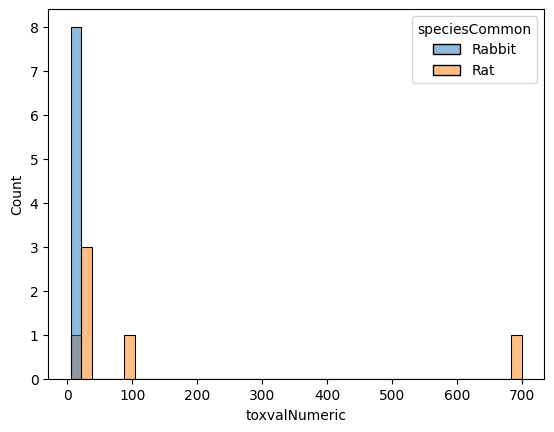

In [28]:
fig, ax = plt.subplots()
sns.histplot(dev_noael_df, x='toxvalNumeric', hue='speciesCommon')
plt.show()

We can always filter our dataframe to look at other study types or criteria. This just illustrates what a useful tool these APIs can be.

To review:

I selected the chemical atrazine due to its use as a common pesticide. The goal was to select and/or develop some tools for characterizing the properties of the chemical. Given the premise of computational toxicology, I decided that simulating a workflow examining properties that a toxicity risk assessor might care about: the bioactivities, in vivo activities, and ADME properties.

Tool Set 1: PubChem and Bioactivity data - I built a small wrapper for PubChem's APIs to access bioactivity data and flag it by search terms that might indicate activities of concern. It flagged developmental toxicity, which is definitely of interest.

Tool Set 2: PubMed, the literature, and language models - I built a small wrapper for manipulating some of PubMed's APIs to grab recent literature on atrazine and applied an LLM (BioGPT-3) to quickly generate a short statement of key findings. Based on this I was able to hone down to some studies that were relevant to the potential developmental, endocrinal, and ecological hazard. In a risk-assessment context I would want to take a look at those studies because they could provide new sources of data or information.

Tool Set 3: Chembl, ADME properties - I built a small wrapper for accessing ChemBL (a data source for pharmaceuticals and therefore containing ADME information) to see if I could find anything on atrazine's absorption, distribution, metabolism, or excretion. It was a modest hit, but we did learn that atrazine has a relatively low (~-5) LogKp, which typically indicates it isn't extremely well absorbed by the skin.

Tool Set 4: ToxRef, DCAP, CTX APIs - I built a small wrapper for accessing the CTX APIs to gather information on the in vivo tox data that is currently public. We can take a look at the spread of these studies, always remembering that a deeper analysis is prudent before drawing any real conclusions.

Thanks for taking a look at this project! I hope you found it interesting! Please note this was a tool for examining how to access useful computational toxicology data through public APIs and should *not* be used to make any formal statements about any of the data without a proper official assessment!